In [1]:
# Check if running on colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# pip install any missing packages
if IN_COLAB:
  !pip install equadratures # for standard pip install

# Data-driven dimension reduction in turbomachinery

In this tutorial, we will look at some of the material in this [ASME Turbo Expo paper](http://dx.doi.org/10.1115/GT2020-16277), which explores the design of a probe used to measure the stagnation temperature in gas-turbine engines. By using *equadratures* to reduce the dimensionality of the design space, the probes' performance parameters can be more effectively visualised, and physical insights obtained.

## Load the data

The data consists of Computational Fluid Dynamics (CFD) simulations of $N=128$ temperature probes, with the upper half of one shown below. The probe geometries are parameterised by $d=7$ design parameters, with the design space sampled using Latin Hypercube sampling. 

<img src="images/probe.jpeg" alt="drawing" style="width:400px;"/>

The input design vectors are stored in $\mathbf{X}\in \mathbb{R}^{N\times d}$, and two design objectives $y_1,y_2 \in \mathbb{R}^{N \times 1}$ are considered. We wish to minimise both of these objectives, which represent the following (see Sections 2 and 6 in the paper for more details):

1. $y_1$: Stagnation pressure loss coefficient $Y_p$ averaged across the Mach number range. 

2. $y_2$: Gradient of recovery ratio w.r.t to Mach number $\partial R_r/\partial M$.

The data can be downloaded from the [equadratures dataset repo](https://github.com/equadratures/data-sets) using the `datasets.load_eq_dataset` method. As in the paper, $X$ is standardised to lie within the interval $[-1,1]$. Unlike in the paper, for commerical privacy reasons, $y_1$, $y_2$ are also standardised here. 

In [31]:
import numpy as np                                                                                                                                                                                      
import matplotlib.pyplot as plt
import equadratures as eq

data = eq.datasets.load_eq_dataset('probes',verbose=False)
X  = data['X']
y1 = data['y1']
y2 = data['y2']
design_params = ['Hole $\oslash$','Kiel $\oslash_{inner}$','Kiel $\oslash_{outer}$',\
           'Kiel lip fwd/back','Hole angle','Hole fwd/back','Hole ellipse'] 

## Find a 1D subspace for loss coefficient
Here we find a subspace for the loss coefficient design objective $y_1$ ($O_{Yp}$ in the paper). From a [previous grid search](https://github.com/ascillitoe/probe-subspaces/blob/main/Example_Notebooks/grid_search.ipynb), we know a 1D subspace ($m=1$) and $1^{st}$ order polynomial ($k=1$) are suitable.

The subspace procedure is not deterministic (there is an element of randomness involved). Sometimes poor subspaces are obtained. We can judge by looking at $R^2$ or simply plotting the summary plot (see later). In this event we simply rerun until we find a subspace we are happy with. This does mean that it is good practice to save a subspace  to file for future analysis, instead of generating a new one each time. 

You can save a subspace with `joblib.dump(mysubspace1,'Yp_subspace.joblib')` for example.

In [45]:
m1 = 1 # number of reduced dimensions
k1 = 1 # polynomial order

# Find subspace via variable projection
mysubspace1 = eq.Subspaces(method='variable-projection',sample_points=X,\
                        sample_outputs=y1,polynomial_degree=k1, subspace_dimension=m1)
    
# Get the subspace vector, and the polynomial approximation
W1 = mysubspace1.get_subspace()[:,0:m1]
u1 = X @ W1
subpoly1 = mysubspace1.get_subspace_polynomial()

It is good practice to check the accuracy of the subspace (we use adjusted $R^2$ here), and also visualise its predictions.

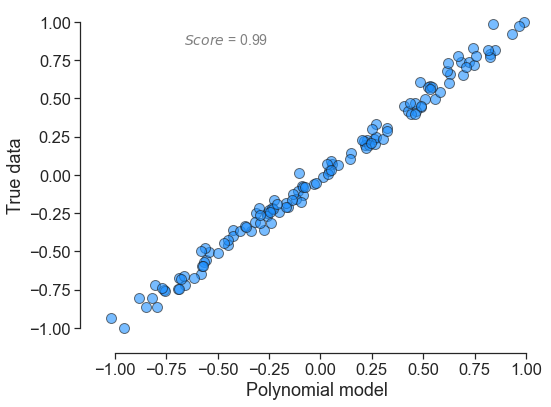

In [46]:
subpoly1.plot_model_vs_data(metric='r2')

If we are happy with the quality of the obtained subspace, we can go ahead and generate a *sufficient summary plot* - a plot which sufficiently describes the variation in the QoI.

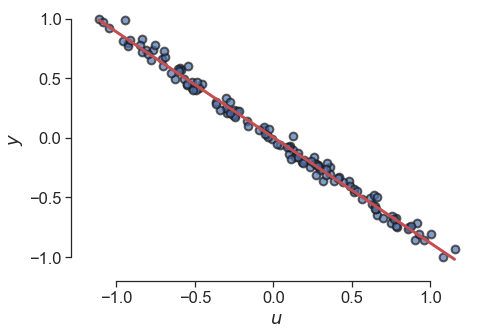

In [47]:
mysubspace1.plot_sufficient_summary()

Here we have obtained a one-dimensional subspace $u=\mathbf{W}^T\mathbf{x}$, which effectively describes the variation in $y$ (the $O_{Y_p}$ design objective). As seen above, this is much easier to visualise than the  original seven dimensional design space.

This ease of visualisation brings with it a more intuitive understanding of the design space. We can observe how designs compare to others in the design space, and look at how to improve designs. To obtain better designs, we need to minimise the loss design objective $O_{Y_p}$. Examining the $\mathbf{W}$ matrix (or vector in this case) reveals how the design must be altered in order to move around the sufficient summary plot (i.e. increase or decrease $u=\mathbf{W}^T\mathbf{x}$).

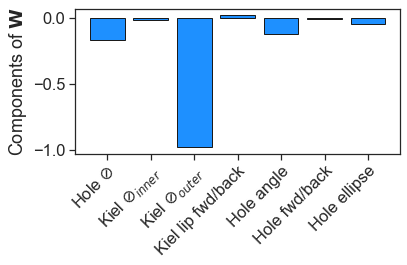

In [48]:
fig, ax = plt.subplots(tight_layout=True)
ax.set_ylabel(r'Components of $\mathbf{W}$')
ax.bar(np.arange(len(W1)),W1.squeeze(),fc='dodgerblue',ec='k')
ax.set_xticks(np.arange(len(W1)))
ax.set_xticklabels(design_params,rotation=45,ha="right",rotation_mode="anchor")
plt.show()

So it is apparent that the Kiel outer diameter has the greatest influence on $u$, and therefore on $O_{Y_p}$, followed by the hole diameter. A decrease in these two diameters leads to a reduction in the loss $O_{Y_p}$. 

## Find a 2D subspace for the recovery ratio gradient
Here we find a subspace for the recovery ratio gradient design objective $y_2$ ($O_{Rr}$ in the paper). From a previous grid search, we know a 2D subspace ($m=2$) and $3^{rd}$ order polynomial ($k=3$) are suitable.

**Note:** This one is trickier! You might need to rerun it a few times to get a good $R^2$ value.

In [41]:
m2 = 2 # number of reduced dimensions
k2 = 3 # polynomial order

# Find subspace via variable projection
mysubspace2 = eq.Subspaces(method='variable-projection',sample_points=X,\
                        sample_outputs=y2,polynomial_degree=k2, subspace_dimension=m2)
    
# Get the subspace vector, and the polynomial approximation
W2 = mysubspace2.get_subspace()
active_subspace2 = W2[:,0:m2]
u2 = X @ active_subspace2
subpoly2 = mysubspace2.get_subspace_polynomial()

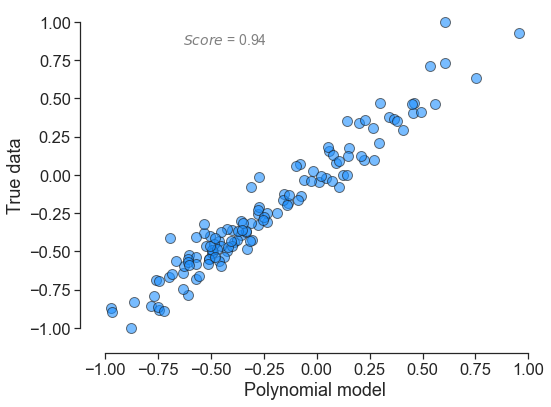

In [42]:
subpoly2.plot_model_vs_data(metric='r2')

Now generate a *sufficient summary plot* again. This time a 2D one!

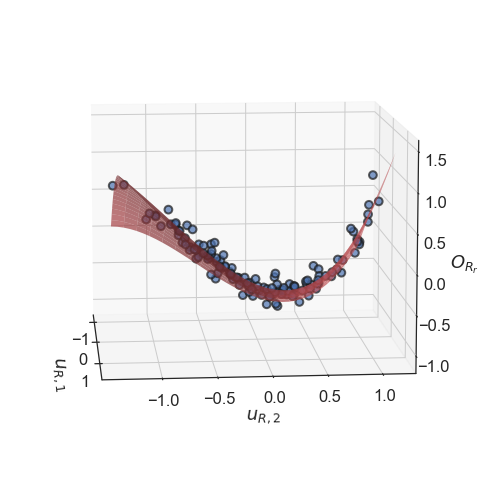

In [43]:
fig = plt.figure(tight_layout=True,figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('$u_{R,1}$',labelpad=10); ax.set_xticks([-1,0,1])
ax.set_ylabel('$u_{R,2}$',labelpad=10)
ax.set_zlabel('$O_{R_r}$',labelpad=10,rotation=0)
ax.zaxis.set_rotate_label(False)
ax.view_init(elev=10, azim=-5)
mysubspace2.plot_sufficient_summary(ax=ax)

Similarly to how the weights of $\mathbf{W}$ were examined to discover designs with lower $O_{Y_p}$, this 2D summary plot can be used to discover designs with lower $O_{R_r}$. In the [ASME Turbo Expo paper](http://dx.doi.org/10.1115/GT2020-16277), we show how the two subspaces can be used together to explore new areas of the design space where $O_{Y_p}$ and $O_{R_r}$ are minimised together. Following this, a third subspace is used to find designs with lower sensitivity to manufacturing uncertainties. 